<a href="https://colab.research.google.com/github/raaz0000002/Google_Earth_Enginene-Collections/blob/main/LULC_NEURAL_Networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:

!pip install rasterio earthpy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 55.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 57.2 MB/s eta 0:00:00


In [5]:

# Load the Drive helper and mount
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
# Import basic packages
import os
import glob
import pandas as pd
import numpy as np

# deep learning related imports
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten, Reshape, GlobalAveragePooling1D, GlobalMaxPooling1D
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Conv1D, MaxPooling1D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# visualization
import rasterio as rio
from rasterio.plot import show
import earthpy as et
import earthpy.spatial as es
import earthpy.plot as ep
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn import preprocessing
%matplotlib inline


In [7]:
# Parameter
FEATURES = ['B4', 'B3', 'B2', 'B8', 'B11', 'B12', 'NDVI', "NDBI", 'MNDWI', 'NDSLI']
LABEL = ['class']
N_CLASSES = 7
CLASSES = [1, 2, 3, 4]
PALETTE = ['#416422','#819A20','#ffffff', '#808080']
SAMPLE_PATH = '/content/drive/MyDrive/Colab Notebooks/lulc_samples.csv'
IMAGE_PATH = '/content/drive/MyDrive/Colab Notebooks/lulc_dhulikhel.tif'


In [8]:

df = pd.read_csv(SAMPLE_PATH)
df.head()


,B4,B3,B2,B8,B11,B12,NDVI,NDBI,MNDWI,NDSLI,class,sample
0,0.04290,0.06475,0.08160,0.15195,0.10655,0.05110,0.559661,-0.175629,-0.244016,-0.425895,1,train
1,0.04735,0.06990,0.08535,0.21070,0.10655,0.05110,0.633017,-0.328290,-0.207708,-0.384665,1,train
2,0.04445,0.06620,0.08315,0.15585,0.10655,0.05110,0.556166,-0.187881,-0.233575,-0.411258,1,train
3,0.04075,0.06050,0.08065,0.12740,0.07850,0.03725,0.515314,-0.237494,-0.129496,-0.316562,1,train
4,0.04075,0.06140,0.08060,0.13190,0.07850,0.03725,0.527947,-0.253802,-0.122230,-0.316562,1,train


In [9]:

# suffle train and test
np.random.seed(42)
df = df.sample(frac=1).reset_index(drop=True)

# # normalize df bands
# band_cols = ['B4', 'B3', 'B2', 'B8', 'B11', 'B12']
# min_val = df[band_cols].min()
# max_val = df[band_cols].max()
# mid_val = (max_val + min_val) / 2

# # normalize B* between -1 and 1
# df[band_cols] = (df[band_cols] - mid_val) / (max_val - min_val)

# df.head()

In [10]:
# train and test split
train = df[df['sample'] == 'train']
test = df[df['sample'] == 'test']

# train and test datasets
train_x = train[FEATURES].to_numpy()
train_x = train_x.reshape(train_x.shape[0], train_x.shape[1], 1)

train_y = train[LABEL].to_numpy()
train_y = to_categorical(train_y, N_CLASSES+1)

test_x = test[FEATURES].to_numpy()
test_x = test_x.reshape(test_x.shape[0], test_x.shape[1], 1)

test_y = test[LABEL].to_numpy()
test_y = to_categorical(test_y, N_CLASSES+1)

print(train_x.shape, train_y.shape, test_x.shape, test_y.shape)

(5376, 10, 1) (5376, 8) (4556, 10, 1) (4556, 8)


In [10]:

# Make model for our data
# Input shape
train_shape = train_x.shape
input_shape = (train_x.shape[1], train_x.shape[2])

print(input_shape)

# Make sequential model
model = keras.Sequential(name="model_conv1D")
model.add(keras.layers.Input(shape=input_shape))
model.add(keras.layers.Conv1D(filters=32, kernel_size=3, activation='relu', name="Conv1D_1"))
model.add(keras.layers.Dropout(0.1))
model.add(keras.layers.Conv1D(filters=16, kernel_size=3, activation='relu', name="Conv1D_2"))
model.add(keras.layers.Conv1D(filters=8, kernel_size=3, activation='relu', name="Conv1D_3"))
model.add(keras.layers.MaxPooling1D(pool_size=2, name="MaxPooling1D"))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(64, activation='relu', name="Dense_1"))
model.add(keras.layers.Dense(32, activation='relu', name="Dense_2"))
model.add(keras.layers.Dense(N_CLASSES+1, name="Dense_3"))
model.add(keras.layers.Activation('softmax'))
model.summary()


(10, 1)


Model: "model_conv1D"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Conv1D_1 (Conv1D)                    │ (None, 8, 32)               │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 8, 32)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv1D_2 (Conv1D)                    │ (None, 6, 16)               │           1,552 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv1D_3 (Conv1D)                    │ (None, 4, 8)                │             392 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ MaxPooling1D (MaxPooling1D)          │ (None, 2, 8)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Dense_1 (Dense)                      │ (None, 64)                  │           1,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Dense_2 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Dense_3 (Dense)                      │ (None, 8)                   │             264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 8)                   │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,504 (21.50 KB)

 Trainable params: 5,504 (21.50 KB)

 Non-trainable params: 0 (0.00 B)

In [11]:
# Train the model

# compile
model.compile(
    optimizer='Adam',
    loss='CategoricalCrossentropy',
    metrics=['accuracy']
)

# Create callback to stop training if loss not decreasing
earlystop = EarlyStopping(
    monitor='loss',
    patience=5
)
modelcheckpoint = ModelCheckpoint(
    filepath='/content/drive/MyDrive/DL/1dcnn.h5',
    monitor='loss',
    save_best_only=True
)

# Fit the model
history = model.fit(
    #validation_split = 0.85 // if large no of dataset are there then it is used.
    x=train_x, y=train_y,
    validation_data=(test_x, test_y),
    batch_size=256,
    callbacks=[earlystop, modelcheckpoint],
    epochs=200,
)

Epoch 1/200
19/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6892 - loss: 1.9586     

21/21 ━━━━━━━━━━━━━━━━━━━━ 7s 60ms/step - accuracy: 0.7186 - loss: 1.9320 - val_accuracy: 1.0000 - val_loss: 1.0811
Epoch 2/200
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9970 - loss: 0.7361 

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9970 - loss: 0.7214 - val_accuracy: 1.0000 - val_loss: 0.0056
Epoch 3/200
20/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9963 - loss: 0.0335 

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9963 - loss: 0.0329 - val_accuracy: 1.0000 - val_loss: 2.4798e-04
Epoch 4/200
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9966 - loss: 0.0311 - val_accuracy: 1.0000 - val_loss: 3.1121e-04
Epoch 5/200
20/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9964 - loss: 0.0297      

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9965 - loss: 0.0291 - val_accuracy: 1.0000 - val_loss: 6.4253e-04
Epoch 6/200
17/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9959 - loss: 0.0293  

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9961 - loss: 0.0278 - val_accuracy: 1.0000 - val_loss: 0.0012
Epoch 7/200
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9965 - loss: 0.0229 

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9965 - loss: 0.0227 - val_accuracy: 1.0000 - val_loss: 0.0014
Epoch 8/200
20/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9981 - loss: 0.0125 

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9980 - loss: 0.0131 - val_accuracy: 1.0000 - val_loss: 0.0015
Epoch 9/200
20/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9979 - loss: 0.0130  

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9978 - loss: 0.0135 - val_accuracy: 1.0000 - val_loss: 0.0015
Epoch 10/200
13/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9975 - loss: 0.0152 

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9973 - loss: 0.0161 - val_accuracy: 1.0000 - val_loss: 0.0016
Epoch 11/200
16/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9981 - loss: 0.0121 

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9978 - loss: 0.0131 - val_accuracy: 1.0000 - val_loss: 0.0015
Epoch 12/200
15/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9978 - loss: 0.0119  

21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.9976 - loss: 0.0127 - val_accuracy: 1.0000 - val_loss: 0.0015
Epoch 13/200
14/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9957 - loss: 0.0196  

21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9962 - loss: 0.0177 - val_accuracy: 1.0000 - val_loss: 0.0014
Epoch 14/200
15/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9959 - loss: 0.0169 

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9962 - loss: 0.0161 - val_accuracy: 1.0000 - val_loss: 0.0015
Epoch 15/200
14/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9965 - loss: 0.0141 

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9967 - loss: 0.0133 - val_accuracy: 1.0000 - val_loss: 0.0011
Epoch 16/200
 1/21 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.9922 - loss: 0.0251

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9957 - loss: 0.0159 - val_accuracy: 1.0000 - val_loss: 0.0012
Epoch 17/200
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9970 - loss: 0.0106 

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9970 - loss: 0.0105 - val_accuracy: 1.0000 - val_loss: 9.8183e-04
Epoch 18/200
 1/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 1.0000 - loss: 0.0014

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9963 - loss: 0.0099 - val_accuracy: 1.0000 - val_loss: 9.2689e-04
Epoch 19/200
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9968 - loss: 0.0080  

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9968 - loss: 0.0080 - val_accuracy: 1.0000 - val_loss: 6.6321e-04
Epoch 20/200
 1/21 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9922 - loss: 0.0133

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9961 - loss: 0.0080 - val_accuracy: 1.0000 - val_loss: 5.9944e-04
Epoch 21/200
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9992 - loss: 0.0030      

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9992 - loss: 0.0031 - val_accuracy: 1.0000 - val_loss: 4.0644e-04
Epoch 22/200
 1/21 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 1.0000 - loss: 0.0031

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9990 - loss: 0.0033 - val_accuracy: 1.0000 - val_loss: 3.4343e-04
Epoch 23/200
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9979 - loss: 0.0048  

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9980 - loss: 0.0047 - val_accuracy: 1.0000 - val_loss: 2.4942e-04
Epoch 24/200
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9990 - loss: 0.0030 

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9990 - loss: 0.0030 - val_accuracy: 1.0000 - val_loss: 1.4415e-04
Epoch 25/200
19/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9993 - loss: 0.0021     

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9993 - loss: 0.0022 - val_accuracy: 1.0000 - val_loss: 1.1824e-04
Epoch 26/200
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9982 - loss: 0.0040 - val_accuracy: 1.0000 - val_loss: 1.1080e-04
Epoch 27/200
20/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9996 - loss: 0.0017  

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9995 - loss: 0.0018 - val_accuracy: 1.0000 - val_loss: 7.3592e-05
Epoch 28/200
 1/21 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 1.0000 - loss: 9.2980e-05

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9994 - loss: 0.0018 - val_accuracy: 1.0000 - val_loss: 7.3211e-05
Epoch 29/200
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9989 - loss: 0.0023 - val_accuracy: 1.0000 - val_loss: 8.3828e-05
Epoch 30/200
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9987 - loss: 0.0025 - val_accuracy: 1.0000 - val_loss: 4.4205e-05
Epoch 31/200
20/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9990 - loss: 0.0024 

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9990 - loss: 0.0024 - val_accuracy: 1.0000 - val_loss: 3.9088e-05
Epoch 32/200
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9985 - loss: 0.0031 - val_accuracy: 1.0000 - val_loss: 2.6222e-05
Epoch 33/200
14/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9984 - loss: 0.0025 

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9985 - loss: 0.0024 - val_accuracy: 1.0000 - val_loss: 1.6286e-05
Epoch 34/200
16/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9993 - loss: 0.0024 

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9992 - loss: 0.0023 - val_accuracy: 1.0000 - val_loss: 1.6450e-05
Epoch 35/200
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9988 - loss: 0.0023 - val_accuracy: 1.0000 - val_loss: 1.9587e-05
Epoch 36/200
15/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9986 - loss: 0.0022 

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9988 - loss: 0.0021 - val_accuracy: 1.0000 - val_loss: 1.0065e-05
Epoch 37/200
12/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9994 - loss: 7.4183e-04  

21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.9992 - loss: 0.0012 - val_accuracy: 1.0000 - val_loss: 1.7374e-05
Epoch 38/200
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9990 - loss: 0.0022 - val_accuracy: 1.0000 - val_loss: 7.4230e-06
Epoch 39/200
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9993 - loss: 0.0015 - val_accuracy: 1.0000 - val_loss: 9.7136e-06
Epoch 40/200
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9984 - loss: 0.0025 - val_accuracy: 1.0000 - val_loss: 2.7913e-05
Epoch 41/200
18/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9994 - loss: 0.0019     

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9994 - loss: 0.0019 - val_accuracy: 1.0000 - val_loss: 3.8463e-06
Epoch 42/200
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9996 - loss: 0.0011 - val_accuracy: 1.0000 - val_loss: 1.0421e-05
Epoch 43/200
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9988 - loss: 0.0023  

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9988 - loss: 0.0023 - val_accuracy: 1.0000 - val_loss: 2.0064e-05
Epoch 44/200
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9991 - loss: 0.0021 

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9991 - loss: 0.0021 - val_accuracy: 1.0000 - val_loss: 5.2413e-06
Epoch 45/200
17/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9990 - loss: 0.0019 

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9991 - loss: 0.0018 - val_accuracy: 1.0000 - val_loss: 7.1258e-06
Epoch 46/200
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9993 - loss: 0.0017 - val_accuracy: 1.0000 - val_loss: 7.1730e-06
Epoch 47/200
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9982 - loss: 0.0025 - val_accuracy: 1.0000 - val_loss: 9.1149e-06
Epoch 48/200
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9995 - loss: 0.0017 - val_accuracy: 1.0000 - val_loss: 1.7007e-06
Epoch 49/200
20/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9994 - loss: 0.0019  

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9994 - loss: 0.0019 - val_accuracy: 1.0000 - val_loss: 1.7663e-06
Epoch 50/200
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9986 - loss: 0.0019     

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9986 - loss: 0.0019 - val_accuracy: 1.0000 - val_loss: 5.4834e-06
Epoch 51/200
18/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9991 - loss: 0.0016     

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9992 - loss: 0.0016 - val_accuracy: 1.0000 - val_loss: 5.4488e-06
Epoch 52/200
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9997 - loss: 9.5701e-04 - val_accuracy: 1.0000 - val_loss: 1.4492e-06
Epoch 53/200
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9984 - loss: 0.0028 - val_accuracy: 1.0000 - val_loss: 9.8162e-06
Epoch 54/200
15/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9995 - loss: 0.0012  

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9994 - loss: 0.0013 - val_accuracy: 1.0000 - val_loss: 1.1853e-05
Epoch 55/200
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9980 - loss: 0.0028 - val_accuracy: 1.0000 - val_loss: 2.6808e-05
Epoch 56/200
15/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9988 - loss: 0.0018 

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9990 - loss: 0.0016 - val_accuracy: 1.0000 - val_loss: 2.1212e-06
Epoch 57/200
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9994 - loss: 0.0015 - val_accuracy: 1.0000 - val_loss: 6.6429e-06
Epoch 58/200
16/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9993 - loss: 0.0011      

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9994 - loss: 0.0012 - val_accuracy: 1.0000 - val_loss: 2.7763e-06
Epoch 59/200
13/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9989 - loss: 0.0013 

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9990 - loss: 0.0013 - val_accuracy: 1.0000 - val_loss: 7.9778e-06
Epoch 60/200
14/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9992 - loss: 8.5921e-04 

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9992 - loss: 0.0010 - val_accuracy: 1.0000 - val_loss: 8.6081e-07
Epoch 61/200
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9994 - loss: 0.0015 - val_accuracy: 1.0000 - val_loss: 1.3657e-06
Epoch 62/200
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9996 - loss: 8.3232e-04  

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9996 - loss: 8.5117e-04 - val_accuracy: 1.0000 - val_loss: 6.9885e-07
Epoch 63/200
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9994 - loss: 0.0016 - val_accuracy: 1.0000 - val_loss: 2.8002e-06
Epoch 64/200
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9997 - loss: 0.0011 - val_accuracy: 1.0000 - val_loss: 4.2823e-06
Epoch 65/200
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9989 - loss: 0.0017 - val_accuracy: 1.0000 - val_loss: 7.8260e-07
Epoch 66/200
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9997 - loss: 8.4656e-04 - val_accuracy: 1.0000 - val_loss: 1.2485e-05
Epoch 67/200
20/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9991 - loss: 9.8294e-04 

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9991 - loss: 0.0010 - val_accuracy: 1.0000 - val_loss: 3.1866e-06
Epoch 68/200
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9998 - loss: 0.0012 - val_accuracy: 1.0000 - val_loss: 6.6270e-06
Epoch 69/200
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9999 - loss: 5.8144e-04 

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9999 - loss: 6.0167e-04 - val_accuracy: 1.0000 - val_loss: 6.9525e-06
Epoch 70/200
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9992 - loss: 0.0012 - val_accuracy: 1.0000 - val_loss: 2.8159e-06
Epoch 71/200
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9998 - loss: 9.0136e-04

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9998 - loss: 9.0019e-04 - val_accuracy: 1.0000 - val_loss: 2.4516e-06
Epoch 72/200
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9995 - loss: 0.0011 - val_accuracy: 1.0000 - val_loss: 4.4995e-06
Epoch 73/200
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9994 - loss: 0.0011 - val_accuracy: 1.0000 - val_loss: 1.8529e-06
Epoch 74/200
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9988 - loss: 0.0021 - val_accuracy: 1.0000 - val_loss: 7.4157e-06
Epoch 75/200
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9997 - loss: 0.0012 - val_accuracy: 1.0000 - val_loss: 3.9133e-07
Epoch 76/200
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9996 - loss: 9.0694e-04 - val_accuracy: 1.0000 - val_loss: 3.8907e-06


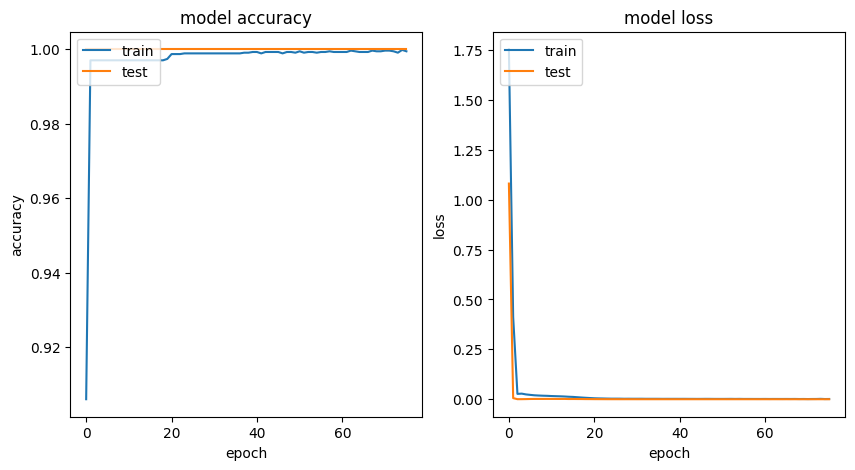

In [12]:

# plot two axis; one for accuracy and another for loss
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].plot(history.history['accuracy'])
ax[0].plot(history.history['val_accuracy'])
ax[0].set_title('model accuracy')
ax[0].set_ylabel('accuracy')
ax[0].set_xlabel('epoch')
ax[0].legend(['train', 'test'], loc='upper left')

ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].set_title('model loss')
ax[1].set_ylabel('loss')
ax[1].set_xlabel('epoch')
ax[1].legend(['train', 'test'], loc='upper left')

plt.show()

In [11]:

# load the best model
model = keras.models.load_model('/content/drive/MyDrive/DL/1dcnn.h5')

143/143 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step
              precision    recall  f1-score   support

           1       1.00      1.00      1.00      4556

    accuracy                           1.00      4556
   macro avg       1.00      1.00      1.00      4556
weighted avg       1.00      1.00      1.00      4556



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


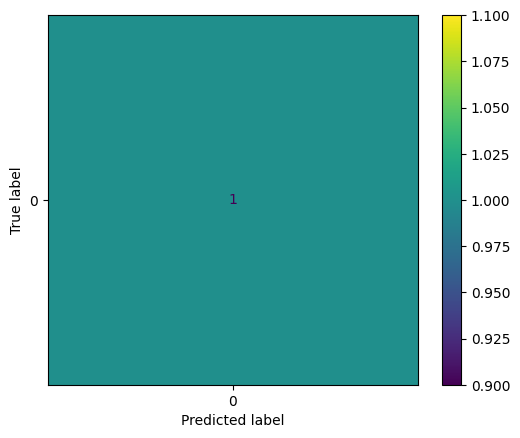

In [12]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Predict
prediction = np.argmax(model.predict(test_x), 1).flatten()
label = np.argmax(test_y, 1).flatten()

cm = classification_report(label, prediction)
print(cm)

# Confusion matrix
cm = confusion_matrix(label, prediction, normalize='true')
cm = ConfusionMatrixDisplay(cm)
cm.plot()

# # Classification report
# print(classification_report(label, prediction))

image_meta:  {'driver': 'GTiff', 'dtype': 'float32', 'nodata': None, 'width': 1080, 'height': 1424, 'count': 10, 'crs': CRS.from_wkt('GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]]'), 'transform': Affine(8.983152841195215e-05, 0.0, 85.53066432617311,
       0.0, -8.983152841195215e-05, 27.68176514319988)}


/usr/local/lib/python3.11/dist-packages/earthpy/spatial.py:561: RuntimeWarning: invalid value encountered in cast
  return (bytedata.clip(low, high) + 0.5).astype("uint8")


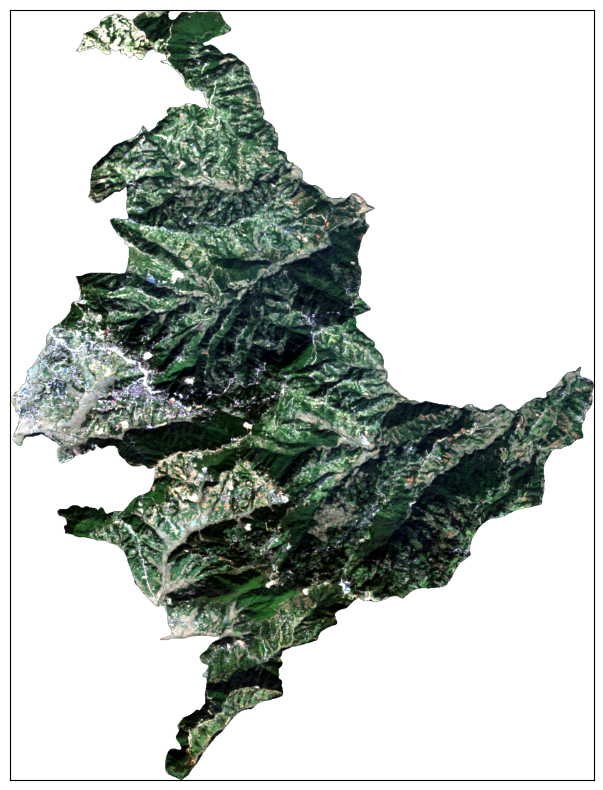

<Axes: >

In [13]:
# load image
img = rio.open(IMAGE_PATH)
print('image_meta: ', img.meta)
full_img = img.read()
rgb = full_img[0:3]

ep.plot_rgb(rgb, figsize=(10, 10), stretch=True)

In [14]:
from matplotlib.colors import from_levels_and_colors

# min_val = full_img[:6].min()
# max_val = full_img[:6].max()
# mid_val = (max_val + min_val) / 2

# full_img[:6] = (full_img[:6] - mid_val) / (max_val - min_val)

# Reshape to (height * width, bands, 1) to match the model's input shape
img_to_predict = full_img.transpose(1, 2, 0).reshape(full_img.shape[1] * full_img.shape[2], full_img.shape[0], 1)
print(img_to_predict.shape)

# Predict
prediction = model.predict(img_to_predict, batch_size=1024*1024)
prediction = np.argmax(prediction, 1)


(1537920, 10, 1)
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step


In [15]:

prediction.shape, full_img.shape

((1537920,), (10, 1424, 1080))

In [16]:


np.unique(prediction)

array([0, 1, 3, 4])

In [17]:

prediction.dtype

dtype('int64')

<matplotlib.colors.ListedColormap object at 0x7f73fc1708d0> <matplotlib.colors.BoundaryNorm object at 0x7f73fc171ed0>


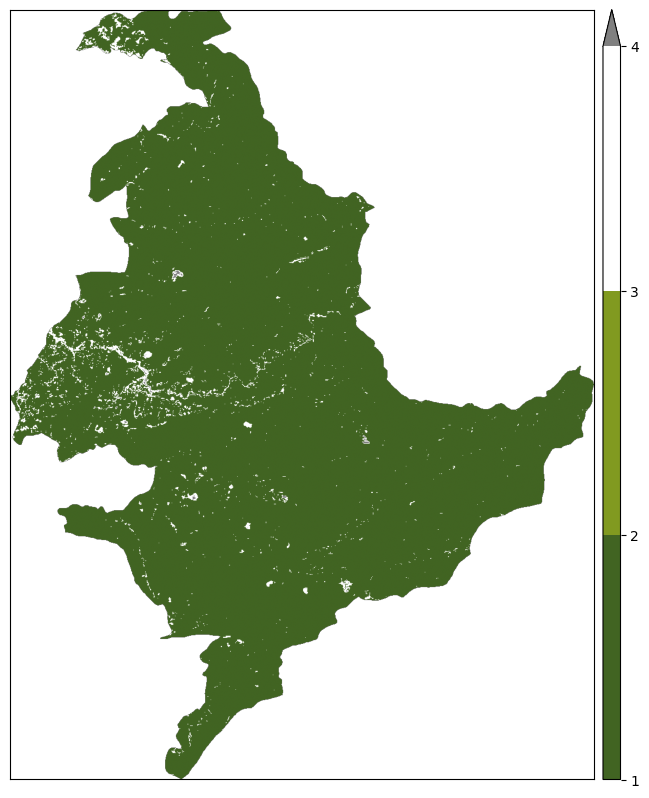

<Axes: >

In [18]:

prediction = prediction.reshape(full_img.shape[1], full_img.shape[2])

# Visualize
cmap, norm = from_levels_and_colors(CLASSES, PALETTE, extend='max')
print(cmap, norm)
ep.plot_bands(prediction, cmap=cmap, norm=norm, figsize=(10, 10))